In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

from collections import defaultdict

%matplotlib inline

algo_order = {'Reinforce':0, 'ActorCritic':1, 'DQN':2, 'DDQN':3}

def load_log(filename):
    df = pd.read_csv(f"./logs/{filename}.csv")
    env_name = filename.split('_')[1].split('-')[0]
    if env_name == 'CartPole':
        df.rename(columns = {
            'state0' : 'cart position',
            'state1' : 'cart velocity',
            'state2' : 'pole angle',
            'state3' : 'pole angular velocity'
            }, inplace = True)
    elif env_name == 'LunarLander':
        df.rename(columns = {
            'state0' : 'horizontal coord',
            'state1' : 'vertical coord',
            'state2' : 'horizontal speed',
            'state3' : 'vertical speed',
            'state4' : 'angle',
            'state5' : 'angular speed',
            'state6' : 'first leg',
            'state7' : 'second leg'
            }, inplace = True)
    return df

def load_log_env_dic(filenames):
    dfs = map(load_log, filenames)
    env_dic = dict()
    for df, filename in zip(dfs, filenames):
        tokens = filename.split('_')
        algo, env, *_ = tokens
        env_dic[env] = env_dic.get(env, dict())

        if algo in env_dic[env]:
            env_dic[env][algo] = pd.concat([env_dic[env][algo], df])
        else:
            env_dic[env][algo] = df
    return env_dic

def get_log_names(filter_str=""):
    PATH = os.path.join(os.getcwd(), 'logs')
    filenames = []
    for name in os.listdir(PATH):
        tokens = [*name.split('.')]
        filename = None
        if len(tokens) > 2:
            filename = '.'.join(tokens[:-1])
        else:
            filename = tokens[0]
        
        filenames.append(filename)
    return list(filter(lambda x: filter_str in x, filenames))


def load_tflog(path_to_events_file):
    from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
    from collections import defaultdict
    ea = EventAccumulator(path_to_events_file)
    ea.Reload()
    data = defaultdict(list)
    for e in ea.Scalars('episode/avg_score'):
        wall_time, step, value = e
        data['wall_time'].append(wall_time)
        data['step'].append(step)
        data['value'].append(value)
    df = pd.DataFrame(data=data)
    return df

def get_tflog_names(path='runs'):
    log_name_list = []
    for (path, dir, files) in os.walk(os.path.join(os.getcwd(), path)):
        for file in files:
            if 'events' in file:
                log_name_list += [os.path.join(*path.split('\\')[-2:], file)]
    return log_name_list

In [ ]:
def cartpole_data_demo():
    df = load_log('ActorCritic_CartPole-v1_1635373522')
    print(df.describe())
    print(df.head(2))
    print(f'데이터 개수: {len(df)}')

    def remove_column():
        # 특정 열 제거
        df2 = df.drop(['reward', 'episode', 'done'], axis=1)
        print(df2.describe())
        print(df2.head(3))
    
    def filtering():
        # 조건 선택
        mask = (df['pole angle']>0.1) | (df['pole angle']<-0.1)
        df2 = df[mask]
        print(df2.describe())
        print(df2.head(2))
    
    def one_hist():
        sns.histplot(df, x="step", y="cart position", cbar=True, cbar_kws=dict(shrink=0.75))
    
    def all_hist():
        sns.pairplot(df, corner=True, kind='hist')
        plt.title("pairplot")
        plt.show()

    one_hist()


def cartpole_data_demo():
    df = load_log('ActorCritic_LunarLander-v2_1635373522')
    print(df.describe())
    print(df.head(2))
    print(f'데이터 개수: {len(df)}')

    def remove_column():
        # 특정 열 제거
        df2 = df.drop(['reward', 'episode', 'done'], axis=1)
        print(df2.describe())
        print(df2.head(3))
    
    def filtering():
        # 조건 선택
        mask = (df['horizontal coord']>0.1) | (df['horizontal coord']<-0.1)
        df2 = df[mask]
        print(df2.describe())
        print(df2.head(2))
    
    def one_hist():
        sns.histplot(df, x="step", y="horizontal coord", 
                        cbar=True, cbar_kws=dict(shrink=0.75),
                        pthresh=0.1, bins=30)
        plt.title("histplot")
        plt.show()
        sns.histplot(df, x="step", y="vertical coord", 
                        cbar=True, cbar_kws=dict(shrink=0.75),
                        pthresh=0.1, bins=30)
        plt.title("histplot")
        plt.show()
    
    def all_hist():
        sns.pairplot(df, corner=True, kind='hist')
        plt.title("pairplot")
        plt.show()

    one_hist()

cartpole_data_demo()

In [ ]:
def cartpole_angle_rate():
    
    log_names = get_log_names('CartPole')
    cartpole_dfs = map(load_log, log_names)
    feature_name = 'pole angle'
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    for i, (df, name) in enumerate(zip(cartpole_dfs, log_names)):
        env, algo, *_ = name.split('_')
        n_total = len(df)
        threshold = 0.0873
        mask = (df[feature_name]>threshold) | (df[feature_name]<-threshold)
        masked_df = df[mask]
        n_masked = len(masked_df)
        print(f'환경: {env}, 알고리즘: {algo}')
        print(f'제한 각도 {threshold}')
        print(f'데이터 수: {n_total}, 제거된 데이터 수 {n_masked}, 비율: {(n_masked)/n_total:.2}')
        
        df['cgroup'] = mask
        sns.histplot(ax=ax[algo_order[env]], data=df, x='step', y=feature_name, hue='cgroup', 
                    bins=30, legend=None)
    plt.show()

cartpole_angle_rate()

In [ ]:
def lunarlander_angle_rate():
    log_names = get_log_names('LunarLander')
    dfs = map(load_log, log_names)
    feature_name = 'angle'

    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    for df, name in zip(dfs, log_names):
        env, algo, *_ = name.split('_')
        n_total = len(df)
        threshold = 0.4
        mask = (df[feature_name]>threshold) | (df[feature_name]<-threshold)
        masked_df = df[mask]
        n_masked = len(masked_df)
        print(f'환경: {env}, 알고리즘: {algo}')
        print(f'제한 각도 {threshold}')
        print(f'데이터 수: {n_total}, 제거된 데이터 수 {n_masked}, 비율: {n_masked/n_total:.2}')
        df['cgroup'] = mask
        sns.histplot(ax=ax[algo_order[env]], data=df, x='step', y=feature_name, hue='cgroup', 
                    bins=30, legend=None)
    plt.show()

lunarlander_angle_rate()

In [ ]:
def cartpole_visualize():
    log_names = get_log_names('CartPole')
    dfs = map(load_log, log_names)
    feature_name = 'pole angle'
    for df, name in zip(dfs, log_names):
        env, algo, *_ = name.split('_')
        n_total = len(df)
        print(f'환경: {env}, 알고리즘: {algo}, 데이터 수: {n_total}')
        fig, ax = plt.subplots(figsize=(5, 5))
        sns.histplot(df, x="step", y="cart position", 
                        cbar=True, cbar_kws=dict(shrink=0.75),
                        bins=30, pthresh=0.05)
        plt.show()
        fig, ax = plt.subplots(figsize=(5, 5))
        sns.histplot(df, x="step", y="pole angle", 
                        cbar=True, cbar_kws=dict(shrink=0.75),
                        bins=30, pthresh=0.05)
        plt.show()

cartpole_visualize()

In [ ]:
def lunarlander_visualize():
    log_names = get_log_names('LunarLander')
    dfs = map(load_log, log_names)
    feature_name = 'pole angle'
    for df, name in zip(dfs, log_names):
        env, algo, *_ = name.split('_')
        n_total = len(df)
        print(f'환경: {env}, 알고리즘: {algo}, 데이터 수: {n_total}')
        fig, ax = plt.subplots(figsize=(5, 5))
        sns.histplot(df, x="step", y="horizontal coord", 
                        cbar=True, cbar_kws=dict(shrink=0.75),
                        bins=30, pthresh=0.05)
        plt.show()
        fig, ax = plt.subplots(figsize=(5, 5))
        sns.histplot(df, x="step", y="vertical coord", 
                        cbar=True, cbar_kws=dict(shrink=0.75),
                        bins=30, pthresh=0.05)
        plt.show()

lunarlander_visualize()

In [ ]:
def total_compare():
        
    def get_compare_statics(env_algo_dic):
        statics = dict()
        for env, algo_dic in env_algo_dic.items():
            statics[env] = statics.get(env, defaultdict(pd.DataFrame))
            for algo, df in algo_dic.items():
                describe = df.describe()
                for col in describe.columns:
                    sr = describe[[col]].squeeze()
                    sr.rename(algo, inplace=True)
                    statics[env][col] = pd.concat([statics[env][col], sr], axis=1)
        return statics

    filenames = get_log_names()
    env_algo_dic = load_log_env_dic(filenames)

    statics = get_compare_statics(env_algo_dic)
    for env in statics:
        for feature in statics[env]:
            print(f'{env}, {feature}')
            print(statics[env][feature])
            print()
        print()

def print_all_describe():
    filenames = get_log_names()
    env_dic = load_log_env_dic(filenames)
    
    for env_name, algo_dic in env_dic.items():
        for algo_name, df in algo_dic.items():
            print(f'{env_name=}, {algo_name=}')
            print(df.describe())

total_compare()

In [ ]:
def cartpole_epi_success_rate():
    filenames = get_log_names(filter_str='CartPole')
    dfs = map(load_log, filenames)
    
    for algo_name, df in zip(filenames, dfs):
        print(f'{algo_name}')
        epi_scores = df.groupby(['episode'])['reward'].sum()
        n_epi = len(epi_scores)
        n_success = len(epi_scores[epi_scores >= 500])
        print(f'{n_epi=}, {n_success=}, {n_success/n_epi:.3}')

cartpole_epi_success_rate()


In [ ]:
def lunarlander_epi_success_rate():
    filenames = get_log_names(filter_str='LunarLander')
    dfs = map(load_log, filenames)
    
    for algo_name, df in zip(filenames, dfs):
        print(f'{algo_name}')
        epi_scores = df.groupby(['episode'])['reward'].sum()
        n_epi = len(epi_scores)
        n_success = len(epi_scores[epi_scores >= 200])
        print(f'{n_epi=}, {n_success=}, {n_success/n_epi:.3}')

lunarlander_epi_success_rate()

In [ ]:


def get_avg_exec_time_step():

    log_name_list = get_tflog_names()
    dfs = map(load_tflog, log_name_list)

    env_dic = dict()

    for name, df in zip(log_name_list, dfs):
        algo, env, *_ = name.split('\\')[1].split('_')
        t = df.at[len(df)-1, 'wall_time'] - df.at[0, 'wall_time']
        n_step = df['step'].max()
        env_dic[env] = env_dic.get(env, dict())
        env_dic[env][algo] = env_dic[env].get(algo, dict())
        env_dic[env][algo]['t'] = env_dic[env][algo].get('t', list())
        env_dic[env][algo]['step'] = env_dic[env][algo].get('step', list())
        env_dic[env][algo]['t'].append(t)
        env_dic[env][algo]['step'].append(n_step)

    for env in env_dic:
        for algo in env_dic[env]:
            print(f'{env=}, {algo=}')
            print(f'n:\t{len(env_dic[env][algo]["t"])}')
            for k, li in env_dic[env][algo].items():
                print(li)
                print(f'{k}:\t{np.average(li):.0f}')

get_avg_exec_time_step()

In [ ]:
def total_compare_with_filter():
        
    def get_compare_statics(env_algo_dic):
        statics = dict()
        for env, algo_dic in env_algo_dic.items():
            statics[env] = statics.get(env, defaultdict(pd.DataFrame))
            for algo, df in algo_dic.items():
                describe = df.describe()
                for col in describe.columns:
                    sr = describe[[col]].squeeze()
                    sr.rename(algo, inplace=True)
                    statics[env][col] = pd.concat([statics[env][col], sr], axis=1)
        return statics

    filenames = get_log_names()
    env_algo_dic = load_log_env_dic(filenames)

    for env in env_algo_dic:
        if 'CartPole' in env:
            pass
                
        if 'LunarLander' in env:
            for algo in env_algo_dic[env]:
                print(f'{env=}, {algo=}')
                threshold = 0.02
                mask = env_algo_dic[env][algo]['vertical coord'] > threshold
                n_before = len(env_algo_dic[env][algo])
                env_algo_dic[env][algo] = env_algo_dic[env][algo][mask]
                n_after = len(env_algo_dic[env][algo])
                print(f'{n_before}에서 {n_before - n_after}개 제거됨')

    statics = get_compare_statics(env_algo_dic)
    for env in statics:
        for feature in statics[env]:
            print(f'{env}, {feature}')
            print(statics[env][feature])
            print()
        print()

total_compare_with_filter()

     algorithm  success_rate  tolerable_rate
0    reinforce         0.668           0.830
1  actorcritic         0.845           0.900
2          dqn         0.922           0.967
3         ddqn         0.998           0.978


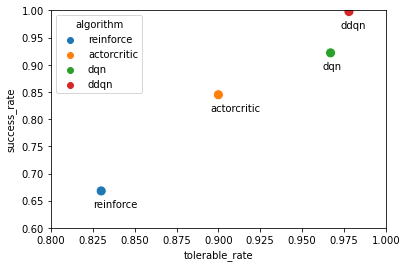

In [39]:
    def compare_algo():
    columns = ['algorithm', 'success_rate', 'tolerable_rate']
    df = pd.DataFrame(columns=columns)

    def label_point(x, y, val, ax):
        a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
        for i, point in a.iterrows():
            ax.text(point['x']+.02, point['y'], str(point['val']))

    def cartpole():
        df.loc[len(df)] = ['reinforce', 0.668, 1-0.17]
        df.loc[len(df)] = ['actorcritic', 0.845, 1-0.1]
        df.loc[len(df)] = ['dqn', 0.922, 1-0.033]
        df.loc[len(df)] = ['ddqn', 0.998, 1-0.022]
        print(df)
        fig, ax = plt.subplots()
        sns.scatterplot(ax=ax, data=df, x='tolerable_rate', y='success_rate', hue='algorithm', s=100)
        ax.set_ylim(0.6, 1)
        ax.set_xlim(0.8, 1)
        for i in range(df.shape[0]):
            plt.text(df.tolerable_rate[i] -0.005, df.success_rate[i]-0.03, s=df.algorithm[i])

    def lunarlander():
        df.loc[len(df)] = ['reinforce', 0.293, 1-0.021]
        df.loc[len(df)] = ['actorcritic', 0.38, 1-0.02]
        df.loc[len(df)] = ['dqn', 0.206, 1-0.017]
        df.loc[len(df)] = ['ddqn', 0.202, 1-0.01]
        print(df)
        fig, ax = plt.subplots()
        sns.scatterplot(ax=ax, data=df, x='tolerable_rate', y='success_rate', hue='algorithm', s=100)
        ax.set_ylim(0.15, 0.45)
        ax.set_xlim(0.977, 0.995)
        for i in range(df.shape[0]):
            plt.text(df.tolerable_rate[i] + 0.0006, df.success_rate[i], s=df.algorithm[i])

    cartpole()

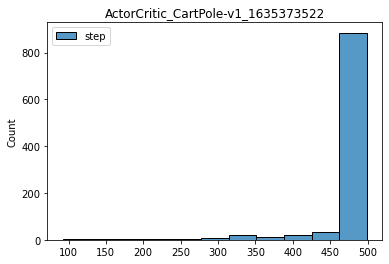

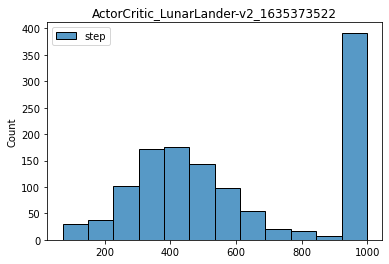

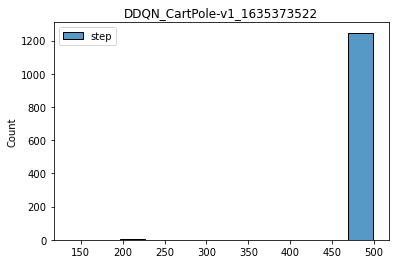

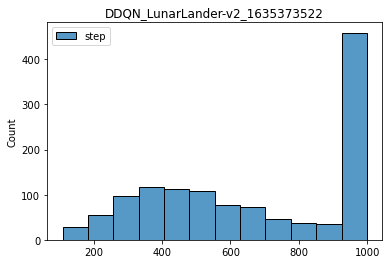

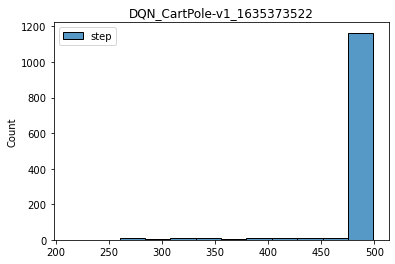

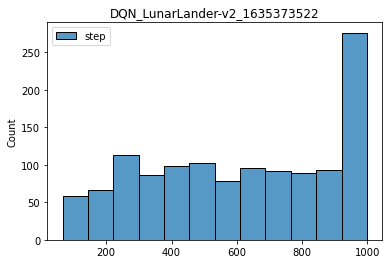

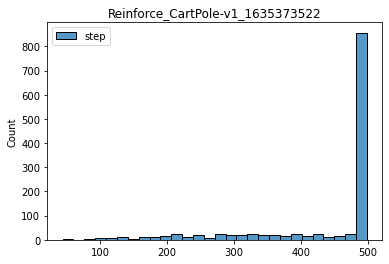

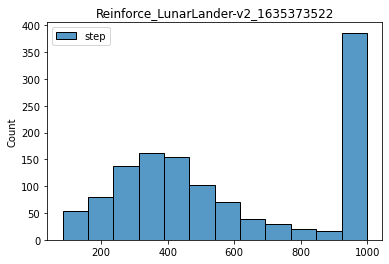

In [57]:
def show_max_step():
    filenames = get_log_names()
    dfs = map(load_log, filenames)
    for df, name in zip(dfs, filenames):
        max_step = pd.DataFrame(df.groupby(['episode'])['step'].max())
        mask = max_step['step'] < 9990
        sns.histplot(max_step[mask])
        plt.title(name)
        plt.show()
